In [1]:
#import libraries & device settings
import sys
import numpy as np
import random
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import einsum
from torch.optim.lr_scheduler import StepLR 
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Subset
#from pytorch_model_summary import summary
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models # generalize above 2 lines 
from torch.utils.tensorboard import SummaryWriter

from mpl_toolkits.mplot3d import Axes3D
import scipy.io as sio
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split

#import models
from perceiver_pytorch import Perceiver
from perceiver_pytorch import Sparceiver

#device setting
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
os.environ['CUDA_LAUNCH_BLOCKING'] = "0"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
print('Count of using GPUs:', torch.cuda.device_count())
print('Current cuda device:', torch.cuda.current_device())
#print(torch.__version__)

np.set_printoptions(threshold=sys.maxsize)

device: cuda
Count of using GPUs: 1
Current cuda device: 0


In [2]:
#Settings - random seed & args
seed = 777
random.seed(seed)  
np.random.seed(seed)
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed) #if use multi-GPU
    #torch.backends.cudnn.enabled = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

torch.set_printoptions(precision=5)
np.set_printoptions(precision=5)

args = { 
    #"augment": 'RandAug',                                      #data augment
    "batch": 18,                                              #batch size
    "numlat": 256,                                            #vector quantization 
    "dim": 128, 
    "depthCross": 1,                                   #iterative depth, [1, 2, 4],
    "depthLatent": 2,                               #latent self-attn depth, [1,2,4,6]
    "mhaLatent": 1,                                       #latent self attn multi head, 1,4,8
    "shareBtwBlocks": True,                           #weight share between (c- and s-) blocks, after the first one

    #"topk":2,
    #"inner2latent":False,
    
    "optimizer": 'SGD',                              #optimizer, ['ADAM', 'SGD']
    "momentum": False,                                 #momentum when optimizing
    "learningRate": 0.01,                      #learning_rate, [0.004, 0.001, 0.0004, 0.0001]
    #"decay": 0.1                              #lr decay for encoder every 100 epoch
}
results = {
    'accuracy_max': None,
    'accuracy_fin': None,
    'loss_min': None,
    'loss_fin': None,
    'epoch_fin': None,
    'path': None,
}

In [3]:
# Load the data
#mat_data_z = loadmat('data/3d_zscoring.mat')
#mat_data = loadmat('data/all_data.mat')
# Extract the matrix from the mat file
#voxel_data = mat_data['data']
#voxel_data_z = mat_data_z['data']
#mat_data = sio.loadmat('data/3d_zscoring.mat')
#voxel_data = mat_data['data']  # Shape: (1800, width, depth, height)
#labels = mat_data_z['labels'].squeeze()  # Shape: (1800,)
#voxel_data = torch.tensor(voxel_data) #in shape 1800, 53, 63, 46

# Constants
num_subject = 15
num_task = 4
NUM_EPOCHS = 1
num_session = 3
frames_per_session = 10

#in shape 1800, 53, 63, 46
#extract nonzero position embedding: 1800, 69059, 1+3


#idx_nonzero = torch.nonzero(voxel_data).reshape(-1, 69058, 4) #in shape (1800, 69058, 4(frame, x, y, z)) frames, nonzero voxels, idx

# Use only non-zero values from the original tensor
#nonzero_voxels = voxel_data[idx_nonzero[:, :, 0], idx_nonzero[:, :, 1], idx_nonzero[:, :, 2], idx_nonzero[:, :, 3]]

#voxels = nonzero_voxels.reshape(180, 10, 69058)

#x = ((idx_nonzero[:,:,1]/53)*(1-(-1)) -1).unsqueeze(2)
#y = ((idx_nonzero[:,:,2]/63)*(1-(-1)) -1).unsqueeze(2)
#z = ((idx_nonzero[:,:,3]/46)*(1-(-1)) -1).unsqueeze(2)
#pos = torch.cat((x, y, z),2 )
#pos = pos.reshape(180,10,69058,3)
#pos.shape

In [4]:
# Define the custom dataset class
class VoxelDataset(Dataset):
    def __init__(self, voxel_data, labels):
        """
        Args:
            voxel_data (Tensor): Tensor of shape (samples, width, depth, height).
            labels (Tensor): Tensor of labels for each sample.
        """
        self.voxel_data = voxel_data
        self.labels = labels
        
    def __len__(self):
        return len(self.voxel_data)
    
    def __getitem__(self, idx):
        # Return a single sample and its label
        return self.voxel_data[idx], self.labels[idx]

# Load the data from .mat files
mat_data_z = loadmat('data/3d_zscoring.mat')
mat_data = loadmat('data/all_data.mat')

# Extract the matrix and labels from the .mat file
voxel_data = torch.tensor(mat_data['data'], dtype=torch.float)  # Ensure data type
labels = torch.tensor(mat_data_z['labels'].squeeze(), dtype=torch.long)  # Ensure labels are long

# Assuming `voxel_data` is your data tensor of shape (1800, 53, 63, 46)
# Reshape to (15 subjects, 4 tasks, 3 sessions, 10 frames, 53, 63, 46)
voxel_data_reshaped = voxel_data.view(15, 4, 3, 10, 53, 63, 46)

# Apply normalization across the 10 frames
# Iterate over subjects, tasks, and sessions
for subject in range(15):
    for task in range(4):
        for session in range(3):
            frames = voxel_data_reshaped[subject, task, session]
            
            # Calculate mean and std along the frames dimension (keeping dimensions for broadcasting)
            mean = frames.mean(dim=0, keepdim=True)
            std = frames.std(dim=0, keepdim=True)
            
            # Avoid division by zero
            std = torch.where(std == 0, torch.ones_like(std), std)
            
            # Normalize
            normalized_frames = (frames - mean) / std
            
            # Store the normalized frames back
            voxel_data_reshaped[subject, task, session] = normalized_frames

# Optionally, flatten the data back to its original shape if needed
voxel_data_normalized = voxel_data_reshaped.view(1800, 53, 63, 46)

# Instantiate the dataset
dataset = VoxelDataset(voxel_data_normalized, labels)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader instances for training and testing
trainloader = DataLoader(train_dataset, batch_size=args["batch"], shuffle=True)
testloader = DataLoader(test_dataset, batch_size=args["batch"], shuffle=False)

In [5]:
# Assuming `voxel_data_normalized` is a PyTorch tensor and `labels` are available
random_index = np.random.randint(0, len(train_dataset))
sample, label = train_dataset[random_index]
sample = sample.numpy()  # Convert to numpy array if it's a tensor

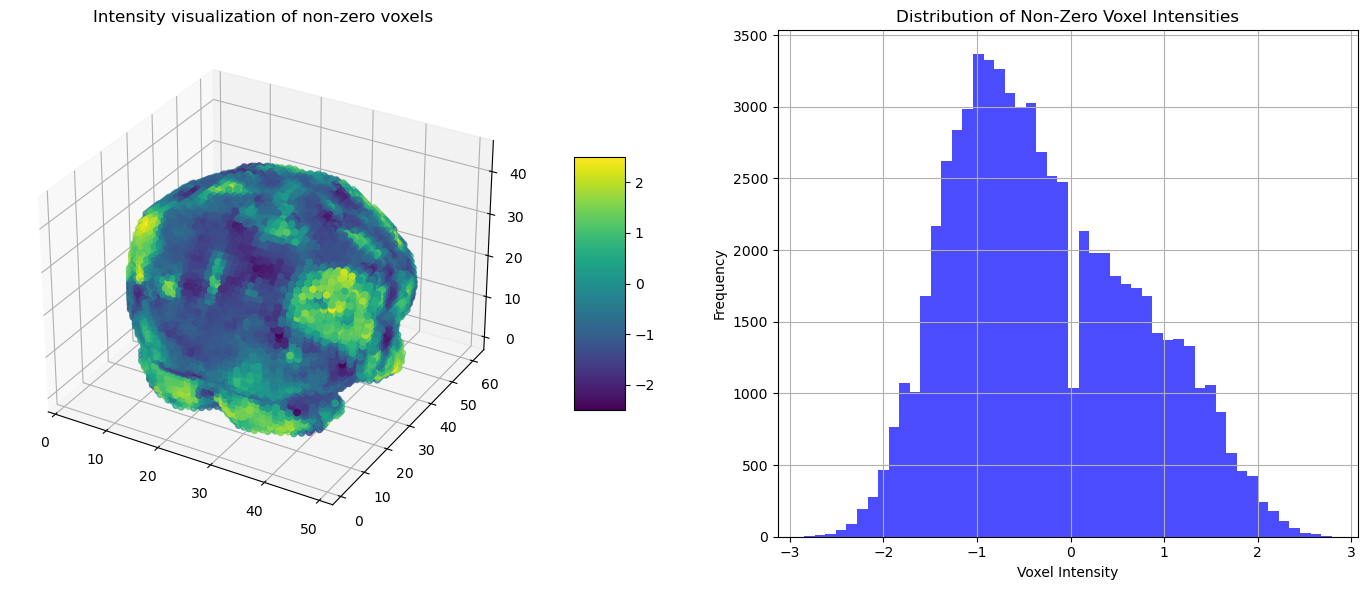

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

def plot_combined(voxel):
    # Set up the figure and subplots
    fig = plt.figure(figsize=(18, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # 3:1 width ratio between two subplots
    
    ax1 = fig.add_subplot(gs[0])
    ax1.set_visible(False)
    ax2 = fig.add_subplot(gs[1])
    ax2.set_visible(False)
    # 3D Voxel Visualization
    ax1 = fig.add_subplot(121, projection='3d')  # 1 row, 2 columns, 1st subplot
    
    x, y, z = np.nonzero(voxel)
    intensities = voxel[x, y, z]
    
    sc = ax1.scatter(x, y, z, c=intensities, cmap='viridis', vmin=-2.5, vmax=2.5, marker='o')
    #ax1.set_xlabel('X Dimension')
    #ax1.set_ylabel('Y Dimension')
    #ax1.set_zlabel('Z Dimension')
    fig.colorbar(sc, ax=ax1, shrink=0.5, aspect=5)
    ax1.set_title('Intensity visualization of non-zero voxels')
    
    # Distribution of Non-Zero Voxel Intensities
    ax2 = fig.add_subplot(122)  # 1 row, 2 columns, 2nd subplot
    
    voxel_values_non_zero = voxel.flatten()
    voxel_values_non_zero = voxel_values_non_zero[voxel_values_non_zero != 0]
    
    ax2.hist(voxel_values_non_zero, bins=50, color='blue', alpha=0.7)
    ax2.set_title('Distribution of Non-Zero Voxel Intensities')
    ax2.set_xlabel('Voxel Intensity')
    ax2.set_ylabel('Frequency')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Assuming 'sample' is your voxel data sample
plot_combined(sample)


In [7]:
#Settings - directory and checkpoints
directory = 'results/fMRI'

def save_checkpoint(directory, state, filename):

    if not os.path.exists(directory):
        os.makedirs(directory)

    path = os.path.join(directory, filename)
    torch.save(state, path)
    #print("=> saving checkpoint")
    
def load_checkpoint(directory, filename):

    path = os.path.join(directory, filename)
    if os.path.exists(path):
        print("=> loading checkpoint")
        state = torch.load(path)
        return state
    else:
        return None
    
if not os.path.exists(directory):
    os.makedirs(directory)
path_df = os.path.join(directory,'table_CIFAR10.csv')

try:
    results_df = pd.read_csv(path_df)
    print('loading existing DataFrame from file.')
except FileNotFoundError:
    #None >> False because None==None returns False...

    results_df = pd.DataFrame(columns=list({**args, **results}))
    #[key for key, value in args.items()]
    #[key for key in args]
    results_df.to_csv(path_df, index=False)
    print('Created a new DataFrame')
print('df path: ',path_df)

argstr = []
for keys in args:
    if len(argstr)!=0:
        argstr += '_'
    argstr += keys + '' + str(args[keys])
argstr = ''.join(argstr)
path = os.path.join(directory,argstr)
print('model path: ',path)

loading existing DataFrame from file.
df path:  results/fMRI/table_CIFAR10.csv
model path:  results/fMRI/batch18_numlat256_dim128_depthCross1_depthLatent2_mhaLatent1_shareBtwBlocksTrue_topk2_inner2latentFalse_optimizerSGD_momentumFalse_learningRate0.01


In [15]:
#Model and Run
lr_list = [0.5]

for lr in lr_list:
    args["learningRate"] = lr

    argstr = '_'.join([f'{key}{args[key]}' for key in args])
    path = os.path.join(directory,argstr)
    print(path)

    model = Perceiver(
        input_channels = 1,          # number of channels for each token of the input
        input_axis = 3,              # number of axis for input data (2 for images, 3 for video)
        num_freq_bands = 4,          # number of freq bands, with original value (2 * K + 1)
        max_freq = 10.,              # maximum frequency, hyperparameter depending on how fine the data is
        depth = args["depthCross"],                   # depth of net. The shape of the final attention mechanism will be:
                                     #   depth * (cross attention -> self_per_cross_attn * self attention)
        num_latents = args["numlat"],           # number of latents, or induced set points, or centroids. different papers giving it different names
        latent_dim = args["dim"],            # latent dimension
        cross_heads = 1,             # number of heads for cross attention. paper said 1
        latent_heads = args["mhaLatent"],            # number of heads for latent self attention, 8
        cross_dim_head = args["dim"],         # number of dimensions per cross attention head
        latent_dim_head = args["dim"],        # number of dimensions per latent self attention head
        num_classes = 4,          # output number of classes
        attn_dropout = 0.,
        ff_dropout = 0.,
        weight_tie_layers = args["shareBtwBlocks"],   # whether to weight tie layers (optional, as indicated in the diagram)
        fourier_encode_data = False,  # whether to auto-fourier encode the data, using the input_axis given. defaults to True, but can be turned off if you are fourier encoding the data yourself
        self_per_cross_attn = args["depthLatent"],      # number of self attention blocks per cross attention
        #topk = args["topk"],
        #inner2latent = args["inner2latent"]
    )
    model = model.to('cuda')

    criterion = torch.nn.CrossEntropyLoss() #logsoftmax + NLL loss?
    #criterion = torch.nn.NLLLoss()
    #criterion = torch.nn.MSELoss()

    if args["optimizer"]=="SGD": optimizer = torch.optim.SGD(model.parameters(), lr=args["learningRate"])    
    #if args["optimizer"]=="ADAM": optimizer = torch.optim.Adam(model.parameters(), lr=args["learningRate"])
    scheduler = StepLR(optimizer, step_size=60, gamma=0.3)
    num_epoch = 200
    start_epoch = 0
    checkpoint = load_checkpoint(directory,argstr)

    if not checkpoint:
        loss_train = []
        loss_val = []
        scr_train = []
        scr_val = []
        #pass
    else:
        start_epoch = checkpoint['epoch'] + 1
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        loss_train = checkpoint['loss_train']
        loss_val = checkpoint['loss_val']
        scr_train = checkpoint['scr_train']
        scr_val = checkpoint['scr_val']

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    start_time = time.time()
    print(time.strftime('%X %x %Z'))
    grads_latent_epoch = []

    for epoch in range(start_epoch, num_epoch):
        #train()--------------------------------------------------------------------------------------
        #print('train///////////////////////////')
        grads_latent_batch = []
        model.train()
        loss_ = 0
        total = 0
        correct = 0
        
        for batch_idx, (data, target) in enumerate(trainloader):
            data, target = data.to(device, dtype=torch.float32).unsqueeze(-1), target.to(device)
            #print(data.shape)
            optimizer.zero_grad()
            output = model(data)
            #output = torch.log(output+1e-7)
            
            #if args["softmaxOut"]==True:
            #    output = F.softmax(output, dim=-1)
            #print("output",output.shape,output,"\ntarget",target.shape,target)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            loss_ += loss.item()
            predicted = torch.argmax(output.data, 1)
            #print(predicted,target)
            total += target.size(0)
            correct += predicted.eq(target.data).cpu().sum()
            #print('p',predicted,'\nt',target)

        scheduler.step()

        loss_train.append(loss_ / (batch_idx + 1))
        scr_train.append(correct / total)
        grads_latent_epoch.append(grads_latent_batch)

        #test()-----------------------------------------------------------------------------------------
        #print('test///////////////////////////')
        model.eval()
        loss_ = 0
        total = 0
        correct = 0
        for batch_idx, (data, target) in enumerate(testloader):
            data, target = data.to(device, dtype=torch.float32).unsqueeze(-1), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            loss_ += loss.item()
            predicted = torch.argmax(output.data, 1)
            total += target.size(0)
            correct += predicted.eq(target.data).cpu().sum()
            #print('p',predicted,'\nt',target)
            
        loss_fin = loss_ / (batch_idx + 1)
        scr_fin = (correct / total).numpy().item()
        loss_val.append(loss_fin)  
        scr_val.append(scr_fin)

        converted_vals = []
        for t in scr_val:
            try:
                converted_vals.append(t.numpy().item())
            except AttributeError:
                converted_vals.append(t)  # If t is not a TensorFlow tensor
        scr_val = converted_vals

        #save results--------------------------------------------------------------------------------------
        save_checkpoint(directory, {
            'epoch': epoch+1,
            'model': model,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss_train': loss_train,
            'loss_val': loss_val,
            'scr_train' : scr_train,
            'scr_val' : scr_val,
        }, argstr)

        # Define the new results dictionary
        new_results = {
            'accuracy_max': max(scr_val),  #val acc
            'accuracy_fin': scr_fin,
            'loss_min': min(loss_train),          #train loss
            'loss_fin': loss_fin,
            'epoch_fin': epoch+1,         #last epoch
            'path': path,
        }

        # Use the loc method to select the rows where the args match the args_to_update dictionary
        mask = (results_df[list(args)] == pd.Series(args)).all(axis=1)
        #print(results_df[list(args)])
        #print(pd.Series(args))
        if mask.any():
            # Update the selected rows and columns with the new results
            #try
            #except
            results_df.loc[mask, new_results.keys()] = new_results.values()
            #results_df.loc[mask, new_results.keys()] = [value.np() for value in new_results.values()]

        else:
            # Append a new row with the new results
            row = {**args, **new_results}
            new_row_df = pd.DataFrame(row, index=[0])
            results_df = pd.concat([results_df, new_row_df], ignore_index=True)

        #Save the updated DataFrame  
        results_df.to_csv(path_df, index=False)

        if epoch%5==0: print(f'Epoch: {epoch + 1:3d}/{num_epoch} || train loss: {loss_train[-1]:.3f} | train acc: {scr_train[-1]:.3f} || val loss: {loss_val[-1]:.3f} | val acc: {scr_val[-1]:.3f}')

    print()
    end_time = time.time() 
    print(time.strftime('%X %x %Z'))
    duration = time.gmtime(end_time - start_time)
    print('{} hours {} mins {} secs for training\n'.format(duration.tm_hour, duration.tm_min, duration.tm_sec))


results/fMRI/batch18_numlat256_dim128_depthCross1_depthLatent2_mhaLatent1_shareBtwBlocksTrue_topk2_inner2latentFalse_optimizerSGD_momentumFalse_learningRate0.5
=> loading checkpoint
02:01:34 02/20/24 KST
Epoch:  21/200 || train loss: 1.394 | train acc: 0.228 || val loss: 1.393 | val acc: 0.244
Epoch:  26/200 || train loss: 1.394 | train acc: 0.237 || val loss: 1.386 | val acc: 0.261
Epoch:  31/200 || train loss: 1.389 | train acc: 0.264 || val loss: 1.397 | val acc: 0.261
Epoch:  36/200 || train loss: 1.393 | train acc: 0.256 || val loss: 1.387 | val acc: 0.247
Epoch:  41/200 || train loss: 1.395 | train acc: 0.236 || val loss: 1.389 | val acc: 0.244
Epoch:  46/200 || train loss: 1.394 | train acc: 0.249 || val loss: 1.388 | val acc: 0.261
Epoch:  51/200 || train loss: 1.392 | train acc: 0.260 || val loss: 1.388 | val acc: 0.261
Epoch:  56/200 || train loss: 1.393 | train acc: 0.219 || val loss: 1.387 | val acc: 0.247
Epoch:  61/200 || train loss: 1.393 | train acc: 0.249 || val loss: 

KeyboardInterrupt: 